In [5]:
import os
import cv2
import numpy as np
import pandas as pd
import datetime
from skimage.feature import local_binary_pattern, hog
from skimage import color
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from hog_extractor import extract_hog_features
from lbp_extractor import extract_lbp_features
from cnn_extractor import load_pretrained_model, extract_cnn_features

Importing Dataset


In [6]:
def load_dataset(dataset_path):
    images = []
    labels = []
    # Each subdirectory is a class corresponding to a person
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Only consider JPG images
            for file in os.listdir(person_path):
                if file.lower().endswith(".jpg"):
                    img_path = os.path.join(person_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        # Resize image to a fixed size
                        img = cv2.resize(img, (128, 128))  # Resize to 128x128
                        if len(img.shape) == 2:  # If grayscale, convert to 3 channels
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

                        images.append(img)
                        labels.append(person)
    return images, labels


dataset_path = 'VGG2_Dataset'
images, labels = load_dataset(dataset_path)
print(f"Loaded {len(images)} images for {len(set(labels))} persons.")


Loaded 16936 images for 50 persons.


In [7]:
print("Number of images:",len(images))
print("Number of labels:", len(labels))
print("size of images:", images[0].shape)

Number of images: 16936
Number of labels: 16936
size of images: (128, 128, 3)


Face Detection and Cropping (For Avoiding Background Noise)

No face detected in image: VGG2_Dataset\n000002\0017_01.jpg
No face detected in image: VGG2_Dataset\n000002\0018_01.jpg
No face detected in image: VGG2_Dataset\n000002\0018_04.jpg
No face detected in image: VGG2_Dataset\n000002\0023_01.jpg
No face detected in image: VGG2_Dataset\n000002\0026_01.jpg
No face detected in image: VGG2_Dataset\n000002\0031_01.jpg
No face detected in image: VGG2_Dataset\n000002\0031_02.jpg
No face detected in image: VGG2_Dataset\n000002\0031_03.jpg
No face detected in image: VGG2_Dataset\n000002\0031_04.jpg
No face detected in image: VGG2_Dataset\n000002\0031_05.jpg
No face detected in image: VGG2_Dataset\n000002\0048_01.jpg
No face detected in image: VGG2_Dataset\n000002\0058_01.jpg
No face detected in image: VGG2_Dataset\n000002\0075_01.jpg
No face detected in image: VGG2_Dataset\n000002\0094_01.jpg
No face detected in image: VGG2_Dataset\n000002\0095_01.jpg
No face detected in image: VGG2_Dataset\n000002\0098_01.jpg
No face detected in image: VGG2_Dataset\

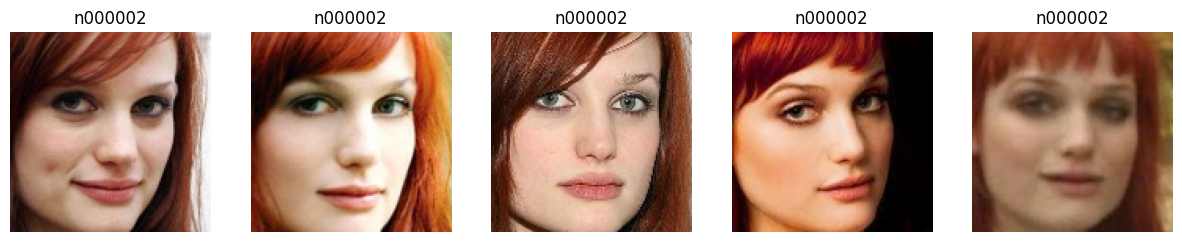

In [8]:
import os
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image in BGR format.
    - cascade_path: Name of the Haar cascade XML file (default is for frontal face detection).
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces (tweak scaleFactor, minNeighbors, minSize as needed)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return None, faces

    # Option: Choose the largest detected face
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    return face_resized, faces

def load_dataset_with_face_detection(dataset_path):
    """
    Loads images from a dataset folder with one subfolder per person, applies face detection and cropping,
    and returns lists of cropped face images and corresponding labels.
    
    Parameters:
    - dataset_path: Path to the main dataset folder.
    
    Returns:
    - cropped_images: List of cropped face images.
    - labels: List of labels corresponding to each image.
    """
    cropped_images = []
    labels = []
    
    # Iterate over each person's folder
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Process only .jpg files
            for file in os.listdir(person_path):
                if file.lower().endswith('.jpg'):
                    img_path = os.path.join(person_path, file)
                    image = cv2.imread(img_path)
                    if image is None:
                        continue
                    # Apply face detection and crop the face
                    face, _ = detect_and_crop_face(image)
                    if face is not None:
                        cropped_images.append(face)
                        labels.append(person)
                    else:
                        print(f"No face detected in image: {img_path}")
    
    return cropped_images, labels

def display_images(images, labels, num_samples=5):
    """
    Displays a few sample images with their labels in a Jupyter Notebook using Matplotlib.
    
    Parameters:
    - images: List of images in BGR format.
    - labels: Corresponding labels.
    - num_samples: Number of samples to display.
    """
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = images[i]
        label = labels[i]
        # Convert from BGR to RGB for correct color display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_rgb)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Example usage in a Jupyter Notebook:
dataset_path = 'VGG2_Dataset'  # Update with your dataset location
images, labels = load_dataset_with_face_detection(dataset_path)
print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons.")

# Display a few sample images inline
display_images(images, labels, num_samples=5)


Example usage of face detection and cropping

Detected 1 face(s) in the image.
Detected face: [[[ 31  28  30]
  [ 31  28  30]
  [ 32  29  31]
  ...
  [197 194 196]
  [197 194 196]
  [198 195 197]]

 [[ 29  26  28]
  [ 29  26  28]
  [ 30  27  29]
  ...
  [198 195 197]
  [200 197 199]
  [203 200 202]]

 [[ 38  35  37]
  [ 36  33  35]
  [ 30  27  29]
  ...
  [196 193 195]
  [202 199 201]
  [206 203 205]]

 ...

 [[ 43  42  51]
  [ 43  42  51]
  [ 40  39  48]
  ...
  [ 79  75  81]
  [ 78  74  80]
  [ 93  89  95]]

 [[ 42  41  50]
  [ 44  43  52]
  [ 42  41  50]
  ...
  [ 84  80  86]
  [ 78  74  80]
  [ 88  84  90]]

 [[ 41  40  50]
  [ 44  43  53]
  [ 43  42  52]
  ...
  [ 85  81  87]
  [ 77  73  79]
  [ 93  89  95]]]
Detected face shape: (151, 151, 3)


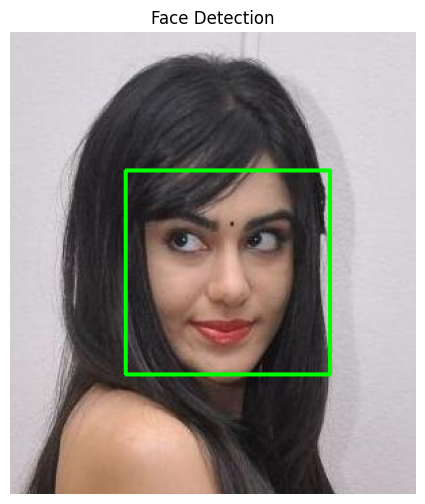

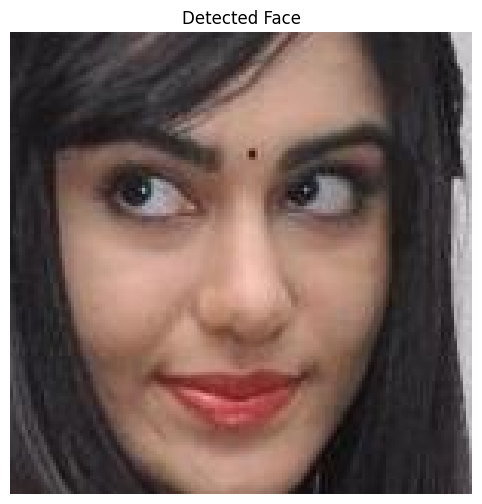

In [9]:
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image (BGR format)
    - cascade_path: Filename for the Haar cascade XML file.
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for the face detector
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Load Haar cascade from OpenCV's data directory
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces: adjust scaleFactor and minNeighbors as needed
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        print("No faces detected.")
        return None, faces

    # For demonstration, take the first detected face (or choose the largest face)
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    # return face_resized, faces
    return face_roi, faces

def show_image(title, image, cmap=None):
    """
    Displays an image using Matplotlib.
    
    Parameters:
    - title: Title of the plot.
    - image: Image array.
    - cmap: Color map (if needed, e.g., 'gray' for grayscale images).
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage in Jupyter Notebook:
img_path = r"VGG2_Dataset\n000043\0002_01.jpg"  # Update with your image path
image = cv2.imread(img_path)

if image is None:
    print("Image not found or unable to load.")
else:
    face, faces = detect_and_crop_face(image)
    print(f"Detected {len(faces)} face(s) in the image.")
    print(f"Detected face: {face}")
    print(f"Detected face shape: {face.shape if face is not None else None}")
    
    # Convert images from BGR to RGB for proper display in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if face is not None:
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        # Draw rectangles on the original image for visualization
        for (x, y, w, h) in faces:
            cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Display the original image with detected face boxes
        show_image("Face Detection", image_rgb)
        
        # Display the cropped face
        show_image("Detected Face", face_rgb)
    else:
        print("No face detected in the image.")


Seeing how an image is  resized

Original image shape: (178, 155, 3)
Resized image shape: (200, 200, 3)


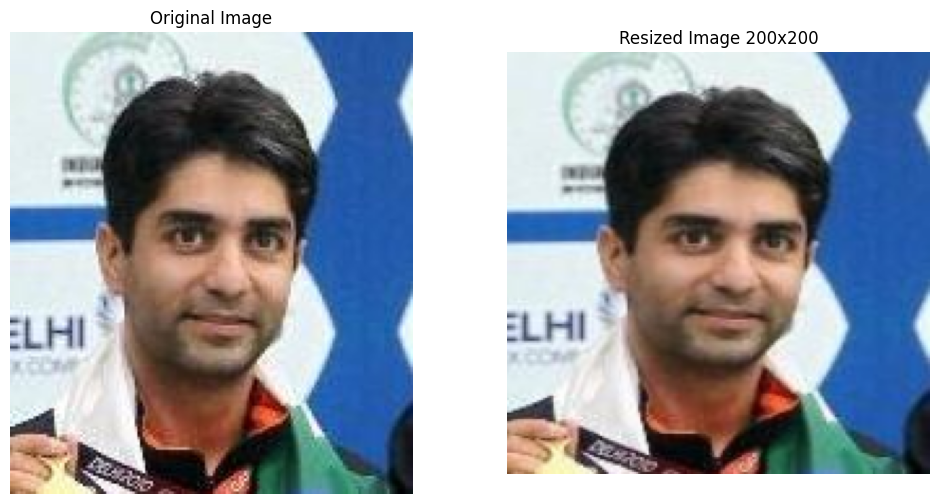

In [10]:
import cv2
import matplotlib.pyplot as plt

# Load the image (update 'path/to/your/image.jpg' with your image path)
image = cv2.imread(r"VGG2_Dataset\n000033\0001_01.jpg")

# Check if image was loaded
if image is None:
    print("Image not found or unable to load.")
else:
    # Print the original image dimensions
    print("Original image shape:", image.shape)

    # Define the target size (width, height)
    target_size = (200, 200)

    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)
    print("Resized image shape:", resized_image.shape)

    # Convert images from BGR (OpenCV default) to RGB for correct display in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the original and resized images side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    # Resized image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_rgb)
    plt.title(f"Resized Image {target_size[0]}x{target_size[1]}")
    plt.axis('off')

    plt.show()


In [11]:
print(images[0].shape)
print(images[0])
print(images[1])
print(labels[0])
print(labels[1])

(128, 128, 3)
[[[ 10  29  79]
  [ 16  32  79]
  [ 26  38  81]
  ...
  [225 223 226]
  [241 240 242]
  [245 245 245]]

 [[ 10  30  81]
  [ 24  40  87]
  [ 19  29  73]
  ...
  [213 212 215]
  [227 226 228]
  [229 229 229]]

 [[ 24  40  82]
  [ 20  33  78]
  [ 16  26  73]
  ...
  [205 205 212]
  [217 215 218]
  [224 219 219]]

 ...

 [[ 22  26  55]
  [ 20  22  46]
  [ 16  15  35]
  ...
  [242 242 242]
  [241 241 241]
  [244 242 242]]

 [[  7  12  40]
  [ 20  23  47]
  [ 23  22  41]
  ...
  [239 239 239]
  [240 240 240]
  [247 245 245]]

 [[ 14  16  39]
  [ 22  23  45]
  [ 16  17  37]
  ...
  [235 234 238]
  [242 241 245]
  [248 245 247]]]
[[[ 25  49 149]
  [ 13  36 137]
  [ 21  43 145]
  ...
  [120 169 159]
  [113 163 149]
  [117 167 149]]

 [[ 28  50 150]
  [  2  25 125]
  [ 22  45 146]
  ...
  [121 172 165]
  [112 165 152]
  [109 162 145]]

 [[ 20  39 137]
  [  9  33 128]
  [ 30  55 149]
  ...
  [127 176 175]
  [112 166 156]
  [106 161 143]]

 ...

 [[ 10  29 108]
  [ 22  39 119]
  [ 17

Extracting LBP features of the Images

In [12]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, radius=1, n_points=8):
    """
    Extract LBP features from an image.
    
    Parameters:
    - image: Input image in BGR or grayscale.
    - radius: Radius of circle (in pixels) for LBP.
    - n_points: Number of points to consider around each pixel.
    
    Returns:
    - hist: Normalized histogram of LBP features.
    """
    # If the image has 3 channels, convert it to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Compute the LBP representation of the image using the "uniform" method
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    
    # Calculate the number of bins. For uniform LBP, the number of bins is n_points + 2
    n_bins = int(n_points + 2)
    
    # Build a histogram of the LBP values
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    return hist

# Example usage:
example_image = cv2.imread('VGG2_Dataset/n000033/0001_01.jpg')
lbp_features = extract_lbp_features(example_image)
print("LBP features:", lbp_features)
print("LBP features shape:", lbp_features.shape)


LBP features: [0.04204422 0.07259877 0.04461762 0.11580283 0.21475172 0.15752084
 0.07303371 0.07825299 0.09797028 0.10340703]
LBP features shape: (10,)


HoG features of the images


In [13]:
from skimage.feature import hog

def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    """
    Extract HoG features from an image.
    
    Parameters:
    - image: Input image in BGR format.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - orientations: Number of gradient orientations.
    
    Returns:
    - hog_features: A feature vector containing the HoG features.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the HoG features
    hog_features = hog(gray,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
    
    return hog_features

# Example usage:
hog_features = extract_hog_features(example_image)
print("HoG features:", hog_features)
print("HoG features shape:", hog_features.shape)

HoG features: [0.4362703  0.         0.07262603 ... 0.2766157  0.2766157  0.18379562]
HoG features shape: (13608,)


Extracting CNN Features

In [14]:
# Load a pretrained CNN (e.g., ResNet18) and remove the classification head
def load_pretrained_model():
    model = models.resnet18(pretrained=True)  # Load ResNet-18
    model = nn.Sequential(*list(model.children())[:-1])  # Remove classification layer
    model.eval()  # Set model to evaluation mode
    return model

# Define preprocessing pipeline for images
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert OpenCV image (NumPy array) to PIL
    transforms.Resize((224, 224)),  # Resize to match CNN input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Extract CNN features from an image
def extract_cnn_features(image, model, device='cpu'):
    """
    Extract deep features using a CNN model.

    Parameters:
    - image: Input image in BGR format (OpenCV format).
    - model: Pretrained CNN model.
    - device: 'cuda' or 'cpu' for computation.

    Returns:
    - feature_vector: Extracted features as a NumPy array.
    """
    if image is None:
        return None

    image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
    image = image.to(device)

    with torch.no_grad():  # Disable gradient computation
        features = model(image)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten to 1D vector

    return features.cpu().numpy().flatten()  # Convert to NumPy array

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_pretrained_model().to(device)

# Example: Extract features from one image
example_image = cv2.imread(r'VGG2_Dataset/n000043/0002_01.jpg')  # Update with actual path
cnn_features = extract_cnn_features(example_image, model, device)
print("CNN Feature Vector Shape:", cnn_features.shape)
print("CNN Features:", cnn_features)


c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNN Feature Vector Shape: (512,)
CNN Features: [7.20678747e-01 8.37577462e-01 2.24133864e-01 3.52831513e-01
 2.00544931e-02 3.18579286e-01 9.10058431e-03 1.02771831e+00
 7.58589149e-01 8.08334470e-01 9.19677734e-01 5.44362485e-01
 7.39613295e-01 4.23242413e-02 4.17786449e-01 3.45564842e-01
 5.68763427e-02 6.77526370e-02 1.99265882e-01 2.06754541e+00
 1.21006727e+00 1.30527699e-02 2.43895993e-01 1.69589549e-01
 9.05408189e-02 4.56832707e-01 1.25029758e-01 2.84074497e+00
 1.67467549e-01 8.80805627e-02 1.56899023e+00 1.10603303e-01
 4.34010386e-01 6.78954422e-01 9.82494593e-01 0.00000000e+00
 1.21803999e+00 2.41411433e-01 1.66529346e+00 5.47162831e-01
 4.41464663e-01 1.16333747e+00 8.02360550e-02 2.73861438e-02
 1.51615298e+00 8.65069151e-01 5.98192573e-01 1.27986038e+00
 2.20465779e+00 1.52395129e+00 6.35180026e-02 2.81638354e-01
 8.74310791e-01 1.01782367e-01 1.46787965e+00 1.65254861e-01
 1.24956518e-01 2.04384208e+00 9.45033908e-01 2.04915613e-01
 6.00722618e-02 0.00000000e+00 8.90302

Extracting features from all images

In [15]:
def extract_all_features(images):
    """
    images: NumPy array of shape (n_samples, 128, 128, 3)
    Returns: combined features of shape (n_samples, combined_feature_length)
    """
    all_features = []
    for idx, img in enumerate(images):
        # Extract features from each image
        # pixel_feat = img.flatten()
        hog_feat = extract_hog_features(img)
        bnp_feat = extract_lbp_features(img)
        cnn_feat = extract_cnn_features(img, model, device)
        
        # Concatenate all features into one vector
        # combined = np.concatenate([pixel_feat, hog_feat, bnp_feat])

        
        # Without pixel features
        combined = np.concatenate([cnn_feat,hog_feat, bnp_feat])
        all_features.append(combined)
    return np.array(all_features)

In [16]:
all_features=extract_all_features(images)
print("Features shape:", all_features.shape)


Features shape: (13550, 8622)


Creating Dataframe 

In [17]:
import pandas as pd

df = pd.DataFrame(all_features)

# Generate column names for features
df.columns = [f'feature_{i}' for i in range(all_features.shape[1])]

# Add the labels column
df['label'] = labels  # Ensure 'labels' has the same length as features

# Display the shape to confirm
print("DataFrame shape:", df.shape)

# Show first few rows
print(df.head())


DataFrame shape: (13550, 8623)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.802077   0.289770   0.128745   0.000000   0.238603   0.237617   
1   1.115850   0.470069   0.052355   0.104749   0.184075   0.382063   
2   1.276201   0.208726   0.306345   0.013597   0.324002   0.243181   
3   0.807578   0.953962   0.029781   0.221374   0.053489   0.001979   
4   1.678613   0.082057   0.103309   0.235502   0.131459   0.028932   

   feature_6  feature_7  feature_8  feature_9  ...  feature_8613  \
0   0.132874   0.249945   0.482863   0.347683  ...      0.057983   
1   0.333543   0.204899   0.545061   0.600433  ...      0.051758   
2   0.313254   0.118908   0.834023   0.340057  ...      0.088074   
3   0.216186   0.132885   0.171244   0.491409  ...      0.042786   
4   0.762626   0.256811   0.166904   1.114931  ...      0.031067   

   feature_8614  feature_8615  feature_8616  feature_8617  feature_8618  \
0      0.047729      0.135986      0.299744      0.156860 

OneHotEncoding for labels


In [18]:
# from sklearn.preprocessing import OneHotEncoder

# # Apply One-Hot Encoding
# one_hot_encoder = OneHotEncoder(sparse_output=False) 
# encoded_labels = one_hot_encoder.fit_transform(df[['label']])  # Convert labels to one-hot encoding

# # Convert to DataFrame with proper column names
# label_columns = [f'label_{i}' for i in range(encoded_labels.shape[1])]

# df_encoded = pd.DataFrame(encoded_labels, columns=label_columns)

# # Drop original label column and concatenate encoded labels
# df = df.drop(columns=['label'])
# df = pd.concat([df, df_encoded], axis=1)


In [19]:
# print(df.head())  # Display first few rows

In [20]:
from sklearn.model_selection import train_test_split

# Features (X) and Labels (y)
# num_classes = len(set(labels))
# X = df.drop(columns=[f"label_{i}" for i in range(num_classes)])  # Feature matrix
# y = df[[f"label_{i}" for i in range(num_classes)]]  # One-hot encoded labels

X=df.drop(columns=['label'])
y=df['label']

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # y contains names of persons

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (10840, 8622), Test set size: (2710, 8622)


Applying ML model

Applying Standard Scaling

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)  # X is your feature matrix

Applying PCA to reduce dimensionality

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # Adjust based on variance plot
X_pca = pca.fit_transform(X_normalized)

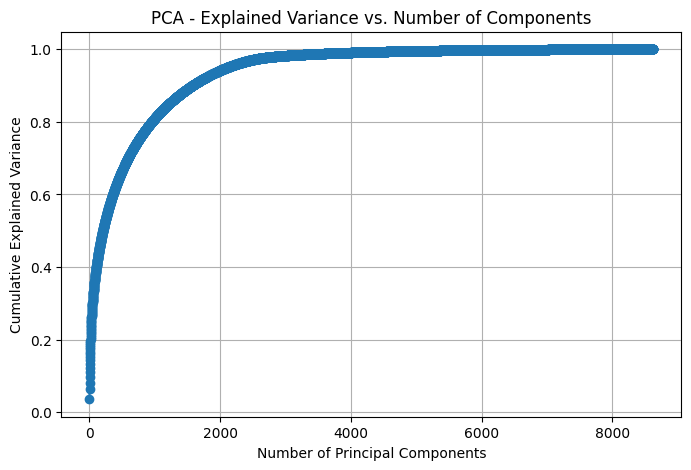

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assume X_normalized is your dataset with 8623 features
pca = PCA()
X_pca = pca.fit_transform(X_normalized)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance vs. Number of Components")
plt.grid()
plt.show()


In [24]:
pca = PCA(n_components=0.95)  # Retains 95% of the variance
X_pca = pca.fit_transform(X_normalized)

print("Number of selected components:", pca.n_components_)


Number of selected components: 2112


Train-Test Split

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (10840, 2112), Test set size: (2710, 2112)


Random Forest Classifier

Original Random Forest Accuracy: 0.9649
Training time: 0.18 seconds

Performing hyperparameter tuning with GridSearchCV...
Fitting 3 folds for each of 324 candidates, totalling 972 fits

Best parameters found: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
GridSearchCV took 75.28 seconds to complete

Optimized Random Forest Accuracy: 0.9649
Training time: 0.12 seconds
Accuracy improvement: 0.00%


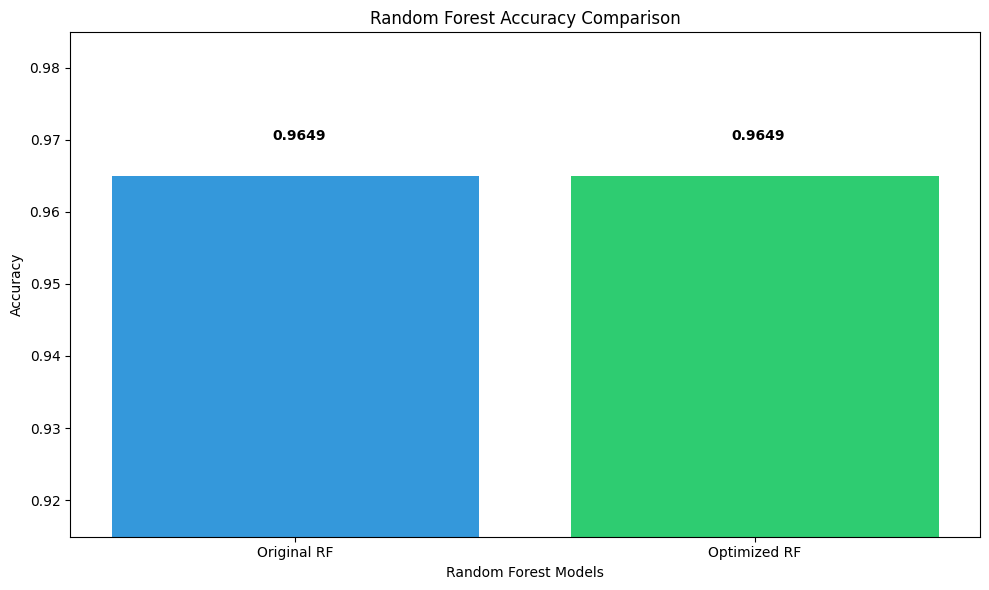

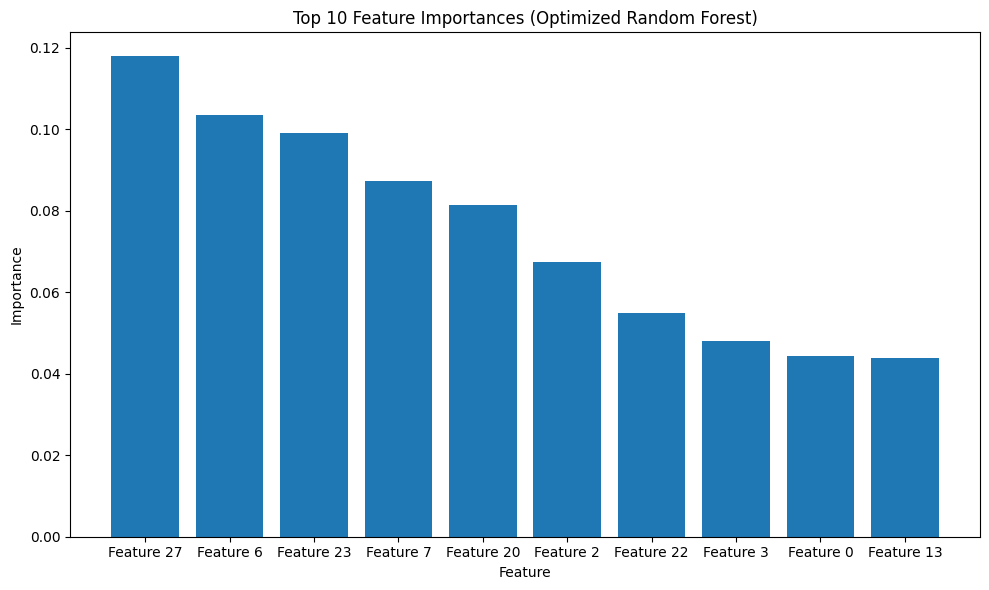

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import time

# Store the original model's accuracy for comparison
start_time = time.time()
rf_original = RandomForestClassifier(
    n_estimators=50,
    max_depth=15,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)

rf_original.fit(X_train, y_train)
original_accuracy = rf_original.score(X_test, y_test)
original_train_time = time.time() - start_time
print(f"Original Random Forest Accuracy: {original_accuracy:.4f}")
print(f"Training time: {original_train_time:.2f} seconds")

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Use GridSearchCV for hyperparameter tuning
print("\nPerforming hyperparameter tuning with GridSearchCV...")
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    scoring='accuracy',
    verbose=1
)

start_time = time.time()
grid_search.fit(X_train, y_train)
tuning_time = time.time() - start_time

# Best parameters and results
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"GridSearchCV took {tuning_time:.2f} seconds to complete")

# Create optimized model with best parameters
rf_optimized = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
rf_optimized.fit(X_train, y_train)
optimized_accuracy = rf_optimized.score(X_test, y_test)
optimized_train_time = time.time() - start_time

print(f"\nOptimized Random Forest Accuracy: {optimized_accuracy:.4f}")
print(f"Training time: {optimized_train_time:.2f} seconds")
print(f"Accuracy improvement: {(optimized_accuracy - original_accuracy) * 100:.2f}%")

# Visualize results
models = ['Original RF', 'Optimized RF']
accuracies = [original_accuracy, optimized_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#3498db', '#2ecc71'])
plt.ylim(max(0.9, min(accuracies) - 0.05), min(1.0, max(accuracies) + 0.02))
plt.xlabel('Random Forest Models')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy Comparison')

# Add accuracy values on top of bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width()/2 - 0.05,
        bar.get_height() + 0.005,
        f"{accuracy:.4f}",
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

# Feature importance of the optimized model
feature_importances = rf_optimized.feature_importances_
feature_names = range(X.shape[1])  # Assuming you have feature names

# Sort features by importance
indices = np.argsort(feature_importances)[::-1]
top_10_indices = indices[:10]  # Show top 10 features

plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_importances[top_10_indices])
plt.xticks(range(10), [f"Feature {i}" for i in top_10_indices])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances (Optimized Random Forest)')
plt.tight_layout()
plt.show()

KNN-Classifier

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Try different k values
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred))


KNN Accuracy: 0.5756457564575646


Support Vector Machine

In [34]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C=1.0, gamma='scale')  # RBF kernel is often best for faces
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))


SVM Accuracy: 0.9473684210526315


DIFFERENT SVM KERNALS


=== SVM Models ===
SVM (linear) Accuracy: 0.9561
SVM (poly) Accuracy: 0.9474
SVM (rbf) Accuracy: 0.9474
SVM (sigmoid) Accuracy: 0.4649

=== SVM Hyperparameter Tuning ===
SVM (best) Accuracy: 0.9561
Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


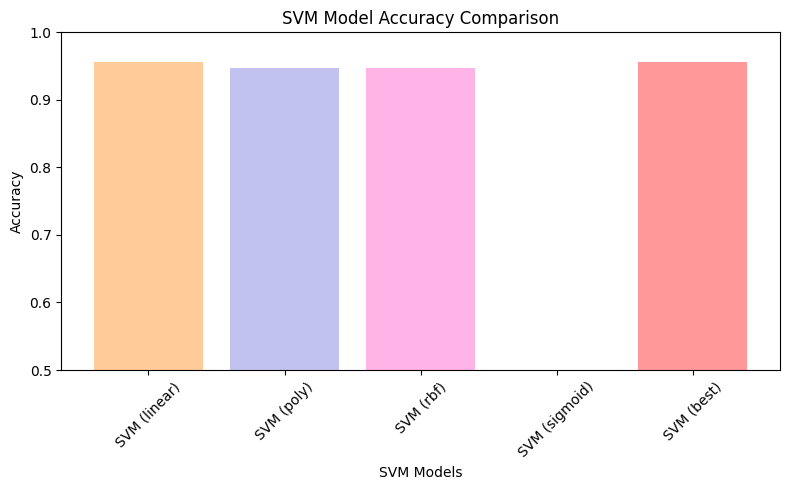

In [39]:
# Import required libraries for SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Store SVM results
svm_results = {}

# ================================
# 1. SVM Models with Different Kernels
# ================================
print("\n=== SVM Models ===")
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:
    svm = SVC(kernel=kernel, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    svm_results[f'SVM ({kernel})'] = acc
    print(f"SVM ({kernel}) Accuracy: {acc:.4f}")

# ================================
# 2. SVM Hyperparameter Tuning
# ================================
print("\n=== SVM Hyperparameter Tuning ===")
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV for SVM tuning
svm_best = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
svm_best.fit(X_train, y_train)
y_pred = svm_best.predict(X_test)
svm_best_acc = accuracy_score(y_test, y_pred)
svm_results['SVM (best)'] = svm_best_acc
print(f"SVM (best) Accuracy: {svm_best_acc:.4f}")
print(f"Best SVM Parameters: {svm_best.best_params_}")

# ================================
# 3. Plot SVM Results
# ================================
plt.figure(figsize=(8, 5))
models = list(svm_results.keys())
accuracies = list(svm_results.values())
colors = ['#ffcc99', '#c2c2f0', '#ffb3e6', '#99ff99', '#ff9999']

plt.bar(models, accuracies, color=colors[:len(models)])
plt.xlabel('SVM Models')
plt.ylabel('Accuracy')
plt.title('SVM Model Accuracy Comparison')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


XGBoost 

=== XGBoost Models ===
XGBoost (basic) Accuracy: 0.9561
XGBoost (improved) Accuracy: 0.9649
Best XGBoost Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


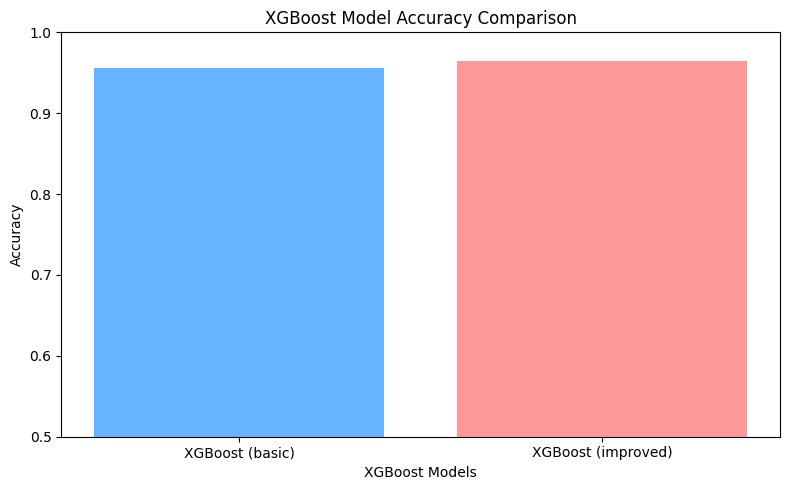

In [37]:
# Import required libraries
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# ============================
# 1. Load and Split the Dataset
# ============================
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store XGBoost results
xgb_results = {}

# ===================================
# 2. Basic XGBoost Model
# ===================================
print("=== XGBoost Models ===")

# Basic XGBoost (default parameters)
xgb_basic = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_basic.fit(X_train, y_train)
y_pred = xgb_basic.predict(X_test)
xgb_basic_acc = accuracy_score(y_test, y_pred)
xgb_results['XGBoost (basic)'] = xgb_basic_acc
print(f"XGBoost (basic) Accuracy: {xgb_basic_acc:.4f}")

# ===================================
# 3. Improved XGBoost with Parameter Tuning
# ===================================
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV for hyperparameter tuning
xgb_improved = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

xgb_improved.fit(X_train, y_train)
y_pred = xgb_improved.predict(X_test)
xgb_improved_acc = accuracy_score(y_test, y_pred)
xgb_results['XGBoost (improved)'] = xgb_improved_acc
print(f"XGBoost (improved) Accuracy: {xgb_improved_acc:.4f}")
print(f"Best XGBoost Parameters: {xgb_improved.best_params_}")

# ================================
# 4. Plot XGBoost Results
# ================================
plt.figure(figsize=(8, 5))
models = list(xgb_results.keys())
accuracies = list(xgb_results.values())
plt.bar(models, accuracies, color=['#66b3ff', '#ff9999'])
plt.xlabel('XGBoost Models')
plt.ylabel('Accuracy')
plt.title('XGBoost Model Accuracy Comparison')
plt.ylim(0.5, 1.0)
plt.tight_layout()
plt.show()


In [ ]:
# ===================================
#  AdaBoost Classifier
# ===================================
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Initialize gb_results to store results
gb_results = {}

# Define and train AdaBoost
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
adaboost.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = adaboost.predict(X_test)
adaboost_acc = accuracy_score(y_test, y_pred)

# Store result in gb_results
gb_results['AdaBoost'] = adaboost_acc
print(f"AdaBoost Accuracy: {adaboost_acc:.4f}")


AdaBoost Accuracy: 0.9649


Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))


Logistic Regression Accuracy: 0.956140350877193


c:\Users\Atanu Kayal\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ensemble Learning